# DMD (Dynamic Mode Decomposition)
DMD produces as linear operator $A$ that advances state $X = X_{t}$ to $X^\prime = X_{t + 1}$. So
$$ X^\prime = A X$$

In [10]:
from scipy.io import loadmat
import os
import numpy as np
import matplotlib.pyplot as plt
# https://github.com/dynamicslab/databook_python/blob/master/DATA/VORTALL.mat
VORTALL_mat = loadmat(os.path.join('data_processing','media','VORTALL.mat'))
print('keys:',*VORTALL_mat.keys())
data = VORTALL_mat['VORTALL']
data.shape

keys: __header__ __version__ __globals__ VORTALL


(89351, 151)

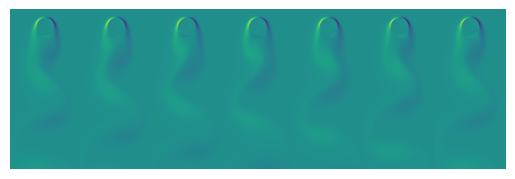

In [32]:
data_present = data.reshape(449,199,151)
data_present = data_present.transpose([2,0,1])
#data_present[0]
plt.imshow(np.hstack(data_present[np.arange(0,35,5)]))
plt.axis('off');

## DMD can be constructed in 4 steps:
<u>Step 1. Compute SVD of X or rank 'r''</u>
$$ X \approx \tilde{U}\tilde{\Sigma}\tilde{V}^\ast$$

<i> see 'clustering/brunton_ch_05.ipynb' for SVD visual interpretation<br>
or 'SVD_singular_value_decompositon/SVD_PCA_tensor_decom_Brunton_2017.ipynb' for general into on SVD </i>


In [45]:
X = data[:,:-1]
X_prim = data[:,1:]
r = 21
U,S,V = np.linalg.svd(X,full_matrices=False)
U_trunk = U[:,:r] 
S_trunk = np.diag(S[:r])
V_trunk = V[:r,:]
S_trunk_inv = np.diag(1/S[:r])


<u>Step 2. Calculate $A$ by inverse</u>

since $$ X^\prime = A X \rightarrow A = X^\prime X^\dag$$

(where $X^\dag$ is a pseudo-inverse of $X$)

We have to find such $A$, that the following exression is minimized
$$A = \underset{A_i}{\mathrm{argmin}}||X^\prime - A_i X||_F = X^\prime X^\dag$$
(where $||\cdot||_F$ is Frobenius norm)


Given $$ X \approx \tilde{U}\tilde{\Sigma}\tilde{V}^\ast$$
Since matrices are of unitary or diagonal, it is easy to calculate an inverse
$$\tilde{V}\tilde{V}^\ast = I; \tilde{\Sigma}^{-1} = 1/\tilde{\Sigma}; \tilde{U}\tilde{U}^\ast = I$$

 
$$X^\dag = \tilde{V}\tilde{\Sigma}^{-1}\tilde{U}^\ast$$

So
$$A = X^\prime X^\dag = X^\prime \tilde{V}\tilde{\Sigma}^{-1}\tilde{U}^\ast$$
But since we only care about low rank representation of $A$,<br>
 we can calculate $A$ expansion into reduced modes $\tilde{U}$
$$\tilde{A} = \tilde{U}^\ast A \tilde{U} = \tilde{U}^\ast(X^\prime \tilde{V}\tilde{\Sigma}^{-1}\tilde{U}^\ast)\tilde{U} =
\tilde{U}^\ast X^\prime \tilde{V}\tilde{\Sigma}^{-1}$$

In [46]:
A_trunk = U_trunk.T @ X_prim @ V_trunk.T @ S_trunk_inv

<u>Step 3. Compute spectral decomposition (eigeonproblem) on $A$;</u>
$$\tilde{A} W = W \Lambda$$
with columns of $W$ being eigenbasis and elements of $\Lambda$ eigenvalues of $A$


In [42]:
lambdas, W = np.linalg.eig(A_trunk)
Lambda = np.diag(lambdas)

<u>Step 4. Construct DMD modes $\Phi$ from $W$ and time-shifted data $X^\prime$;</u>

$$\Phi = X^\prime \tilde{V} \tilde{\Sigma}^{-1} W$$



In [47]:
Phi = X_prim @ V_trunk.T @ S_trunk_inv @ W


Cannot comment much here... except, notice if
$$A = X^\prime \tilde{V}\tilde{\Sigma}^{-1}\tilde{U}^\ast$$
$$\tilde{A} W = W \Lambda$$
Then we can see that eigenmodes of DMD $\Phi$ are eigenvectors of original data matrix $A$ with eigenvalues $\Lambda$
$$A\Phi = (X^\prime \tilde{V}\tilde{\Sigma}^{-1}
\underbrace{\tilde{U}^\ast)(X^\prime \tilde{V} \tilde{\Sigma}^{-1}}_{\tilde{A}} 
W)$$
$$= X^\prime \tilde{V}\tilde{\Sigma}^{-1}(\tilde{A} W) = X^\prime \tilde{V} \tilde{\Sigma}^{-1} (W \Lambda)$$
$$ (X^\prime \tilde{V} \tilde{\Sigma}^{-1} W) \Lambda= \Phi \Lambda$$

(-0.5, 448.5, 198.5, -0.5)

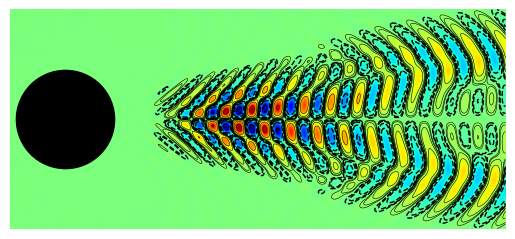

In [50]:
## Plot Mode 2
vortmin = -5
vortmax = 5
V2 = np.copy(np.real(np.reshape(Phi[:,1],(449,199))))
V2 = V2.T

# normalize values... not symmetric
minval = np.min(V2)
maxval = np.max(V2)

if np.abs(minval) < 5 and np.abs(maxval) < 5:
    if np.abs(minval) > np.abs(maxval):
        vortmax = maxval
        vortmin = -maxval
    else:
        vortmin = minval
        vortmax = -minval

V2[V2 > vortmax] = vortmax
V2[V2 < vortmin] = vortmin

plt.imshow(V2,cmap='jet',vmin=vortmin,vmax=vortmax)

cvals = np.array([-4,-2,-1,-0.5,-0.25,-0.155])
plt.contour(V2,cvals*vortmax/5,colors='k',linestyles='dashed',linewidths=1)
plt.contour(V2,np.flip(-cvals)*vortmax/5,colors='k',linestyles='solid',linewidths=0.4)

plt.scatter(49,99,5000,color='k') # draw cylinder

plt.axis('off')


Data entry $x_k$ at time $t = k$ can be expanded in terms of DMD modes $\Phi$.

DMD modes $b$ of initial state can be calculcated from $$ x_1 = \Phi b$$
by taking a pseudo inverse $$ \Phi^\dag x_1 =  b $$
and $$x_k = \sum_{j = 1}^{r} \phi_j \lambda_j^{k-1}b_j = \Phi \Lambda^{k-1} b$$

notice 
$$x_{k=1} = \Phi \Lambda^{0} b = \Phi I b = \Phi I \Phi^\dag x_1  = x_1$$

Generally, procedure reminds of repeated application of Operator $A$ to advance $x_k$ to $x_{k+n}$

$$x_2 = A x_1; x_3 = A x_2 = A ( A x_1) = A^2 x_1; \dots$$

In practice, similarly like with $\tilde{A}$, we can compute $$ x_1 = \Phi b$$ using reduced $\tilde{x}_1$, which leads to 
$$b = (W\Lambda)^{-1}\tilde{x}_1$$

In [ ]:
gamma1 = S_trunk @ V_trunk[:,0]
b = np.linalg.solve(W @ Lambda,gamma1)

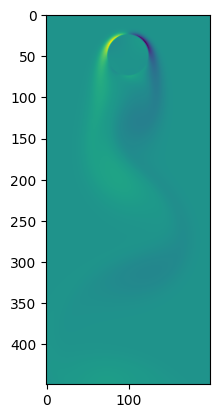

In [57]:
x0 = (Phi @ b).reshape((449,199)).real
plt.imshow(x0)